## 1D Heat Equation using Physics-Informed Neural Networks (PINNs)

This notebook solves the **1D heat equation**:

$$
u_t = \alpha u_{xx},
$$

where \(u(x, t)\) represents temperature along a 1D rod of length 1, and \$\alpha$ is the thermal diffusivity.  

The Physics-Informed Neural Network is trained to:
- Satisfy the PDE residual,
- Match the initial condition u(x, 0) = $\sin(\pi x)$,
- Enforce zero Dirichlet boundary conditions \(u(0, t) = u(1, t) = 0\).  

The model predicts the spatio-temporal temperature distribution and is compared against the analytical solution:

$$
u(x, t) = e^{-\alpha \pi^2 t} \sin(\pi x).
$$


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)

x_b0 = tf.zeros((500,1),dtype=tf.float32)
x_b1 = tf.ones((500,1),dtype=tf.float32)
t_b = tf.constant(np.linspace(0,1,500).reshape(-1,1),dtype=tf.float32)
xt_b0 = tf.concat([x_b0,t_b],axis=1)
xt_b1 = tf.concat([x_b1,t_b],axis=1)

x_p = tf.constant(np.linspace(0,1,500).reshape(-1,1),dtype=tf.float32)
t_p = tf.constant(np.linspace(0,1,500).reshape(-1,1),dtype=tf.float32)

x_i = tf.constant(np.linspace(0,1,500).reshape(-1,1),dtype=tf.float32)
t_i = tf.zeros((500,1),dtype=tf.float32)
Xt_i = tf.concat([x_i,t_i],axis=1)
u_i = tf.sin(np.pi * x_i)

x_test = np.linspace(0, 1, 100)
t_test = np.linspace(0, 1, 100)
x, t = np.meshgrid(x_test, t_test)
xt_test = np.hstack([x.flatten()[:, None], t.flatten()[:, None]])
xt_test_tensor = tf.constant(xt_test, dtype=tf.float32)

In [ ]:
alpha = 0.1

def exact_solution(x, t):
    return tf.exp(-alpha * np.pi**2 * t) * tf.sin(np.pi * x)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(1)
])

Epoch 0, Loss: 0.8352328538894653


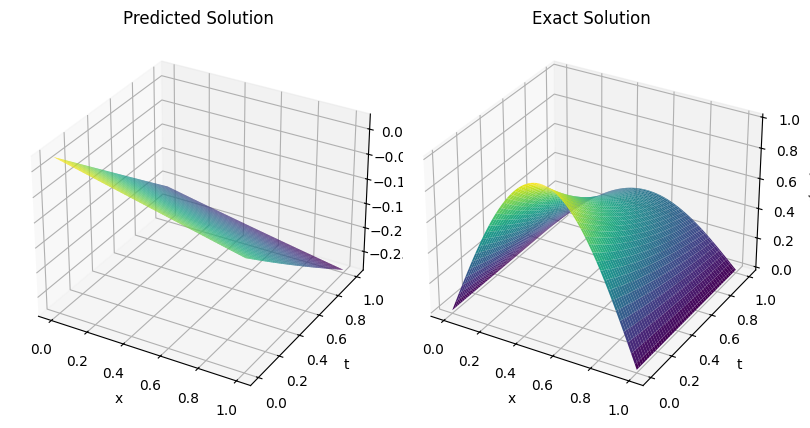

Epoch 1000, Loss: 0.0005231824470683932


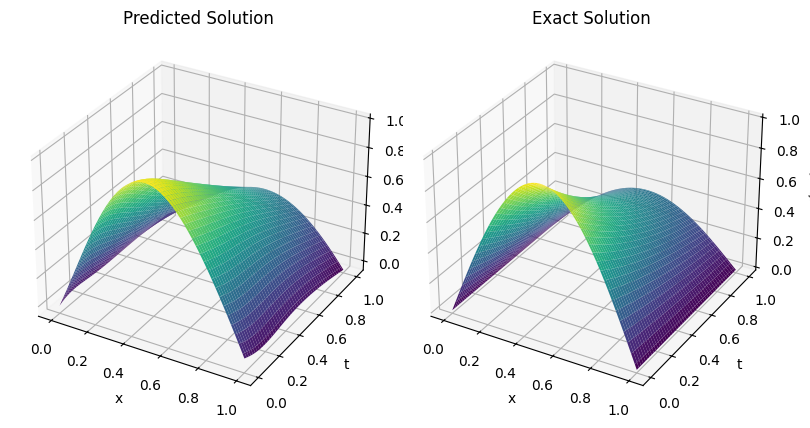

Epoch 2000, Loss: 0.00022310200438369066


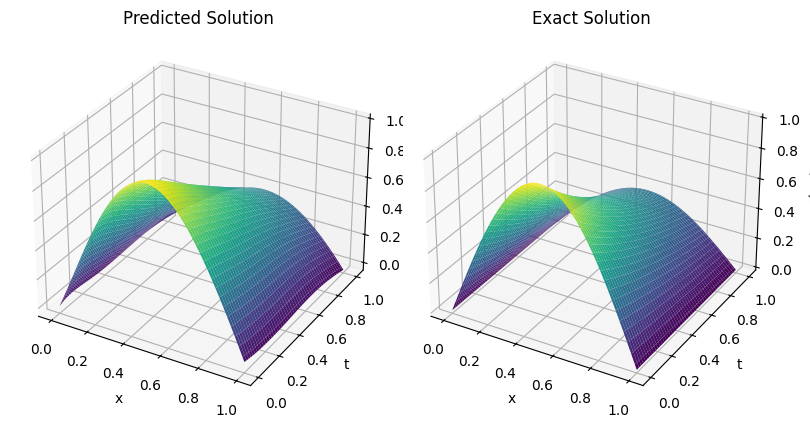

Epoch 3000, Loss: 6.824732554377988e-05


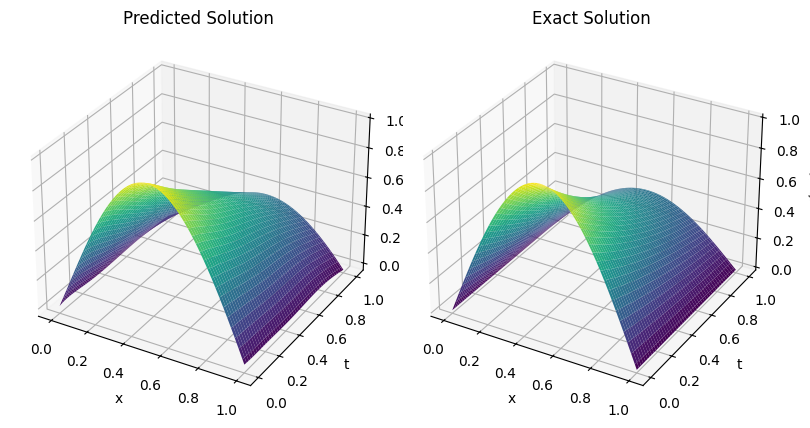

Epoch 4000, Loss: 0.0004217513487674296


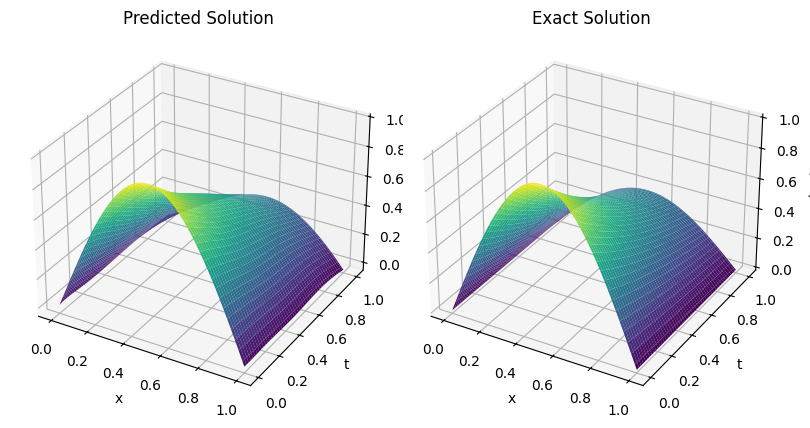

Epoch 5000, Loss: 6.725240382365882e-05


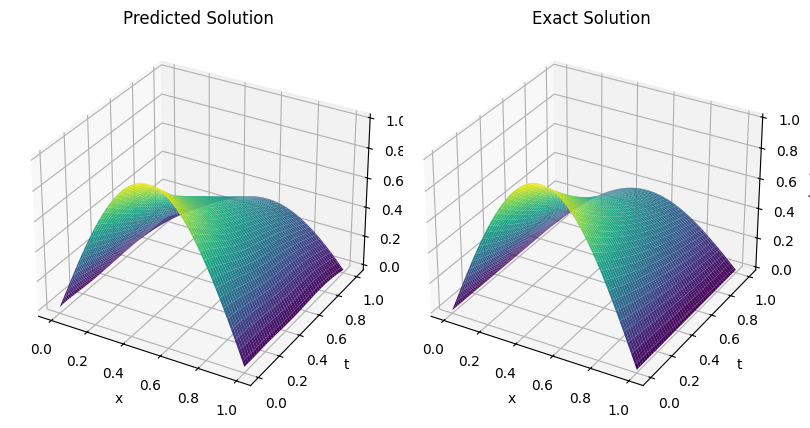

Epoch 6000, Loss: 1.98596444533905e-05


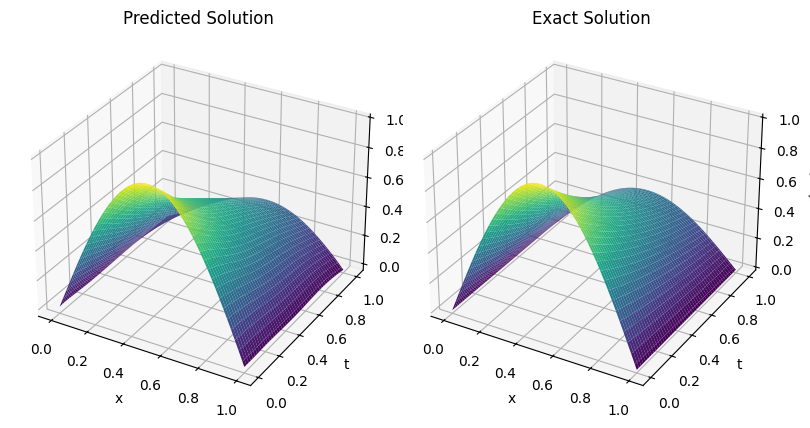

Epoch 7000, Loss: 7.774538971716538e-05


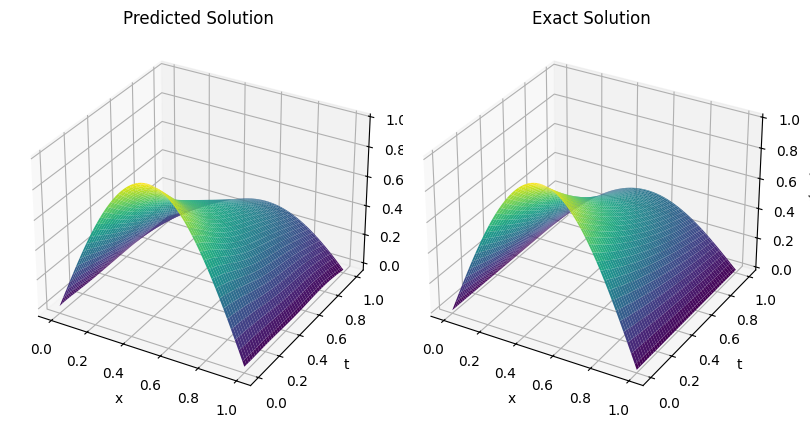

Epoch 8000, Loss: 1.2350097676971927e-05


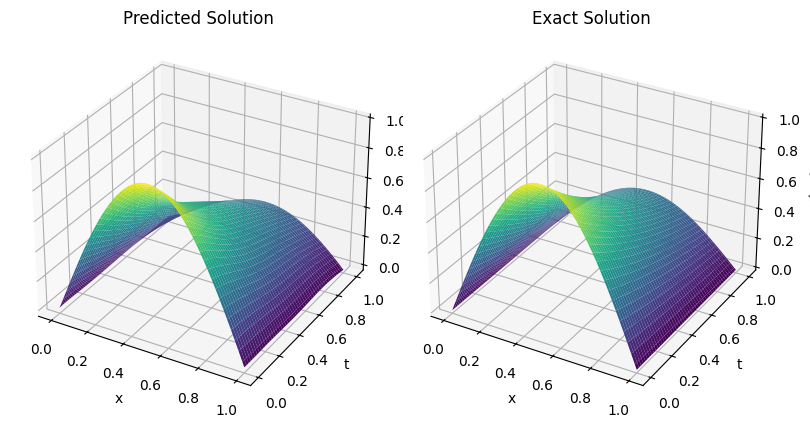

Epoch 9000, Loss: 8.911123586585745e-06


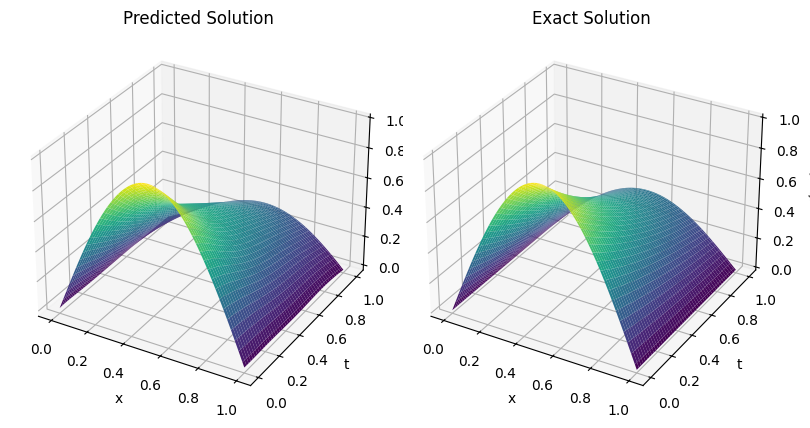

Epoch 10000, Loss: 7.71943450672552e-06


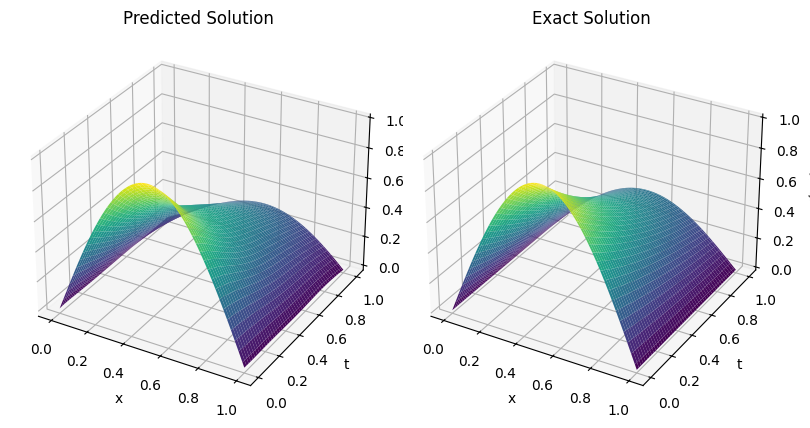

Epoch 11000, Loss: 6.129855137260165e-06


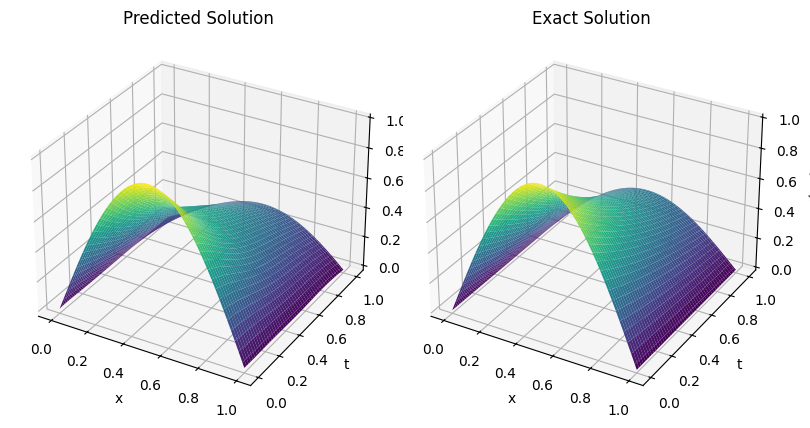

Epoch 12000, Loss: 1.774478005245328e-05


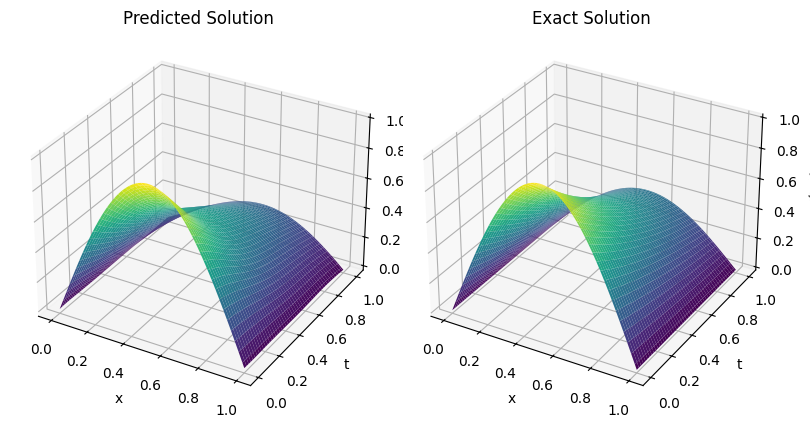

Epoch 13000, Loss: 4.342305146565195e-06


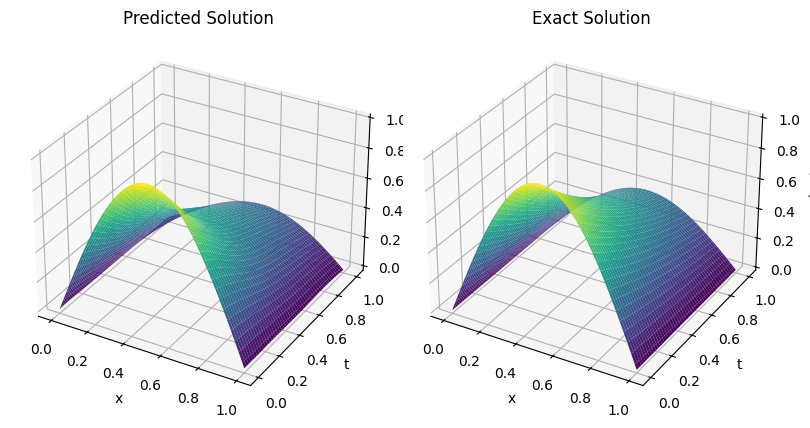

Epoch 14000, Loss: 3.685999217850622e-06


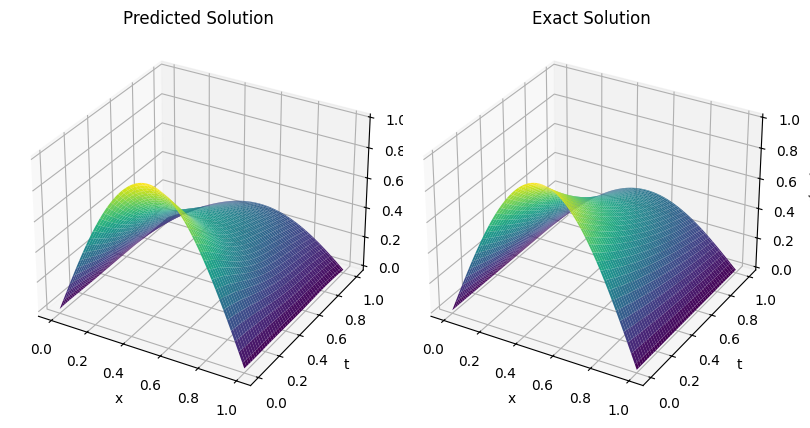

Epoch 15000, Loss: 3.110717898380244e-06


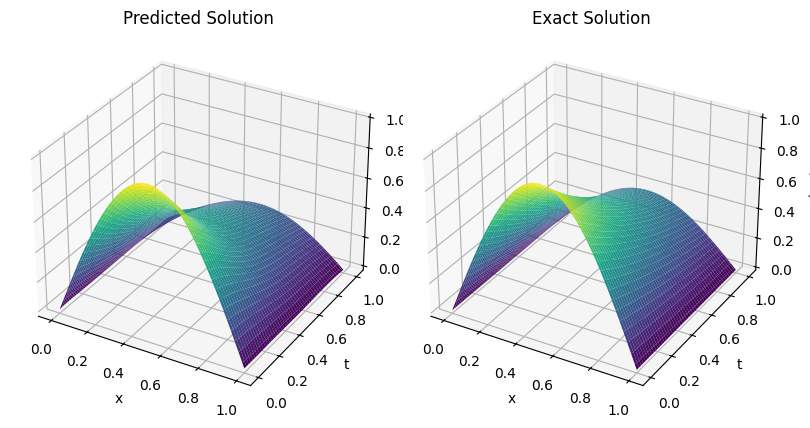

Epoch 16000, Loss: 2.764739292615559e-06


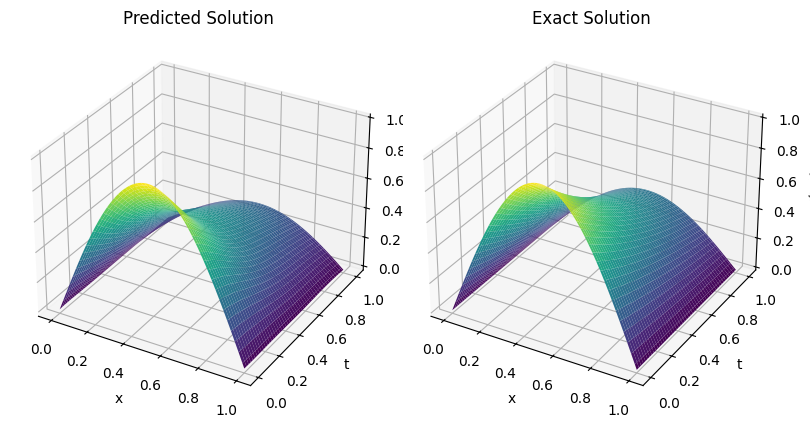

Epoch 17000, Loss: 2.4906601083785063e-06


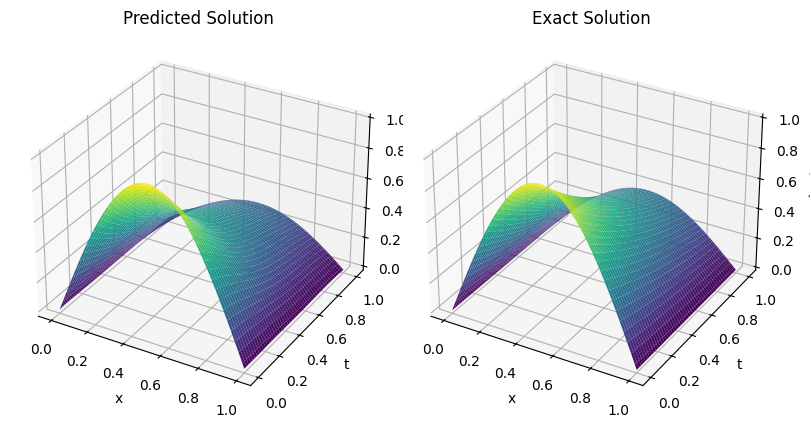

Epoch 18000, Loss: 7.28497298041475e-06


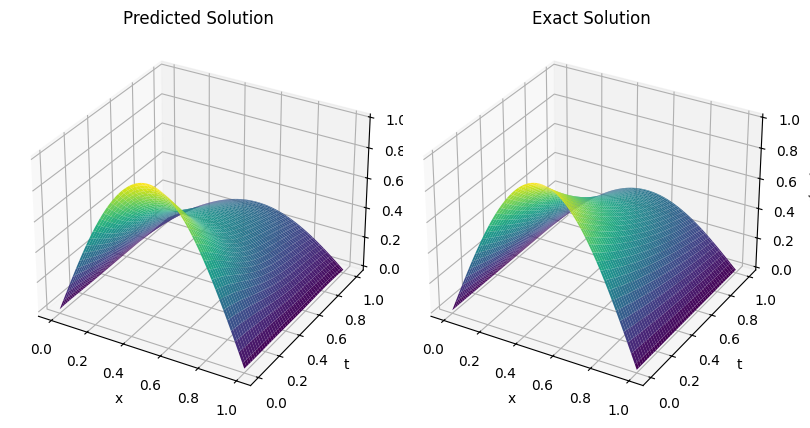

Epoch 19000, Loss: 2.4516550638509216e-06


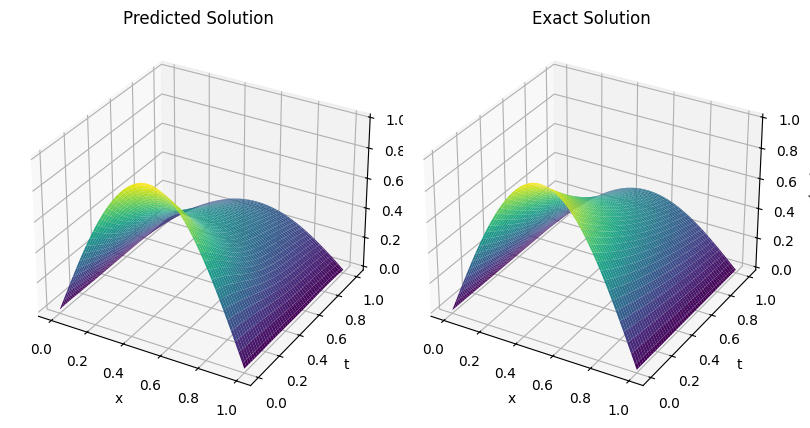

Epoch 20000, Loss: 2.7598507585935295e-06


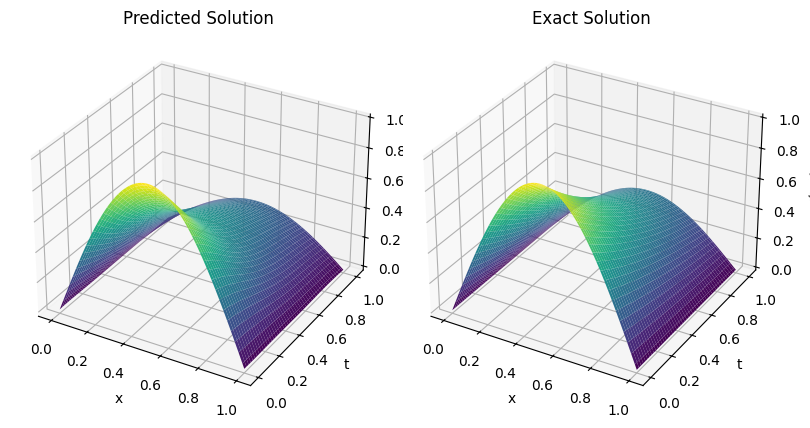

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 20001

for epoch in range(epochs):
  with tf.GradientTape() as tape:

    up_b = tf.concat([model(xt_b0), model(xt_b1)], axis=0)
    up_i = model(Xt_i)

    b_loss = tf.reduce_mean(tf.square(up_b))
    i_loss = tf.reduce_mean(tf.square(up_i - u_i))

    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch([x_p,t_p])
      xt_p = tf.concat([x_p,t_p],axis=1)
      up_p = model(xt_p)

      u_t = tape2.gradient(up_p, t_p)
      u_x = tape2.gradient(up_p, x_p)
      u_xx = tape2.gradient(u_x, x_p)

      p_loss = tf.reduce_mean(tf.square(u_t - alpha * u_xx))

      del tape2

    loss = b_loss + i_loss + p_loss

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  if epoch % 1000 == 0:
    print(f"Epoch {epoch}, Loss: {loss.numpy()}")

    u_pred = model(xt_test_tensor).numpy().reshape(100, 100)
    u_exact = exact_solution(xt_test[:,0], xt_test[:, 1]).numpy().reshape(100,100)

    fig = plt.figure(figsize=(8,6))

    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(x, t, u_pred, cmap='viridis')
    ax.set_title("Predicted Solution")
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_zlabel("u(x,t)")

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_surface(x, t, u_exact, cmap='viridis')
    ax.set_title("Exact Solution")
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_zlabel("u(x,t)")

    plt.tight_layout()
    plt.show()


In [ ]:
alpha = 0.25

x_obs = tf.constant(np.linspace(0,1,200).reshape(-1,1),dtype=tf.float32)
t_obs = tf.constant(np.linspace(0,1,200).reshape(-1,1),dtype=tf.float32)
xt_obs = tf.concat([x_obs,t_obs],axis=1)
u_obs = np.exp(-alpha * np.pi**2 * t_obs) * np.sin(np.pi * x_obs) + 0.01 * np.random.randn(200,1)

x_b0 = tf.zeros((500,1),dtype=tf.float32)
x_b1 = tf.ones((500,1),dtype=tf.float32)
t_b = tf.constant(np.linspace(0,1,500).reshape(-1,1),dtype=tf.float32)
xt_b0 = tf.concat([x_b0,t_b],axis=1)
xt_b1 = tf.concat([x_b1,t_b],axis=1)

x_p = tf.constant(np.linspace(0,1,500).reshape(-1,1),dtype=tf.float32)
t_p = tf.constant(np.linspace(0,1,500).reshape(-1,1),dtype=tf.float32)

x_i = tf.constant(np.linspace(0,1,500).reshape(-1,1),dtype=tf.float32)
t_i = tf.zeros((500,1),dtype=tf.float32)
Xt_i = tf.concat([x_i,t_i],axis=1)
u_i = tf.sin(np.pi * x_i)

x_test = np.linspace(0, 1, 100)
t_test = np.linspace(0, 1, 100)
x, t = np.meshgrid(x_test, t_test)
xt_test = np.hstack([x.flatten()[:, None], t.flatten()[:, None]])
xt_test_tensor = tf.constant(xt_test, dtype=tf.float32)

In [ ]:
def exact_solution(x, t):
    return tf.exp(-alpha * np.pi**2 * t) * tf.sin(np.pi * x)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(1)
])

alpha_train = tf.Variable(1.0, dtype=tf.float32, trainable=True)

Epoch 0, Loss: 0.8088032603263855


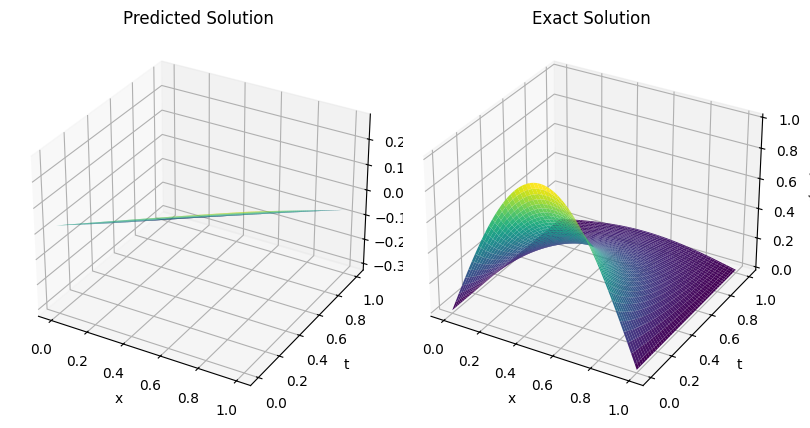

Epoch 4000, Loss: 0.00047352895489893854


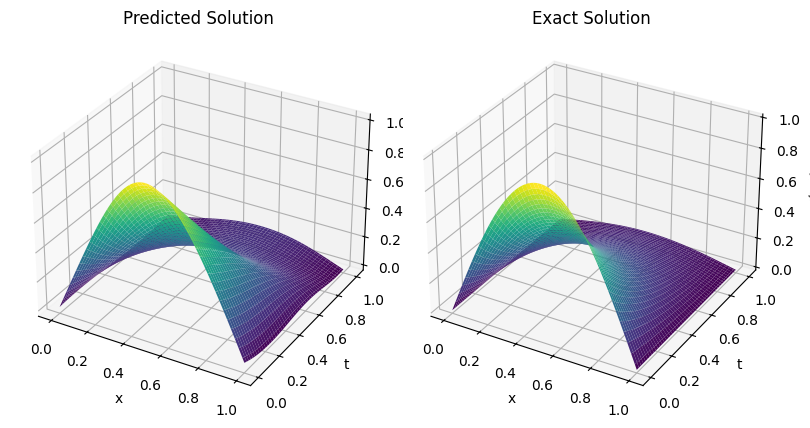

Epoch 8000, Loss: 0.0005227928049862385


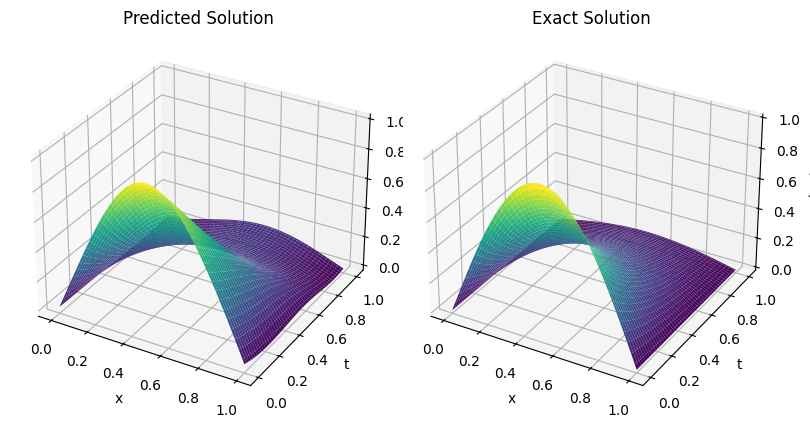

Epoch 12000, Loss: 0.00021662443759851158


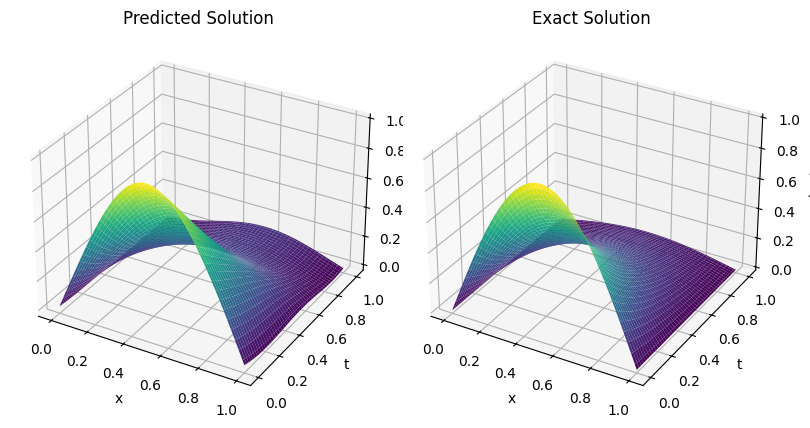

Epoch 16000, Loss: 0.0001537409843876958


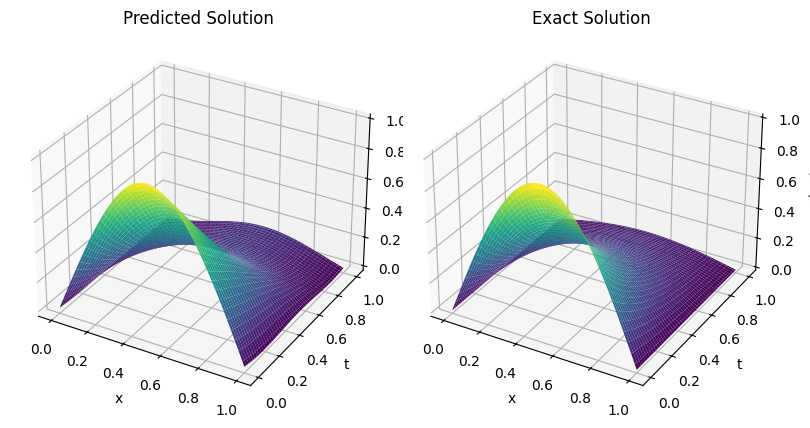

Epoch 20000, Loss: 0.00013071477587800473


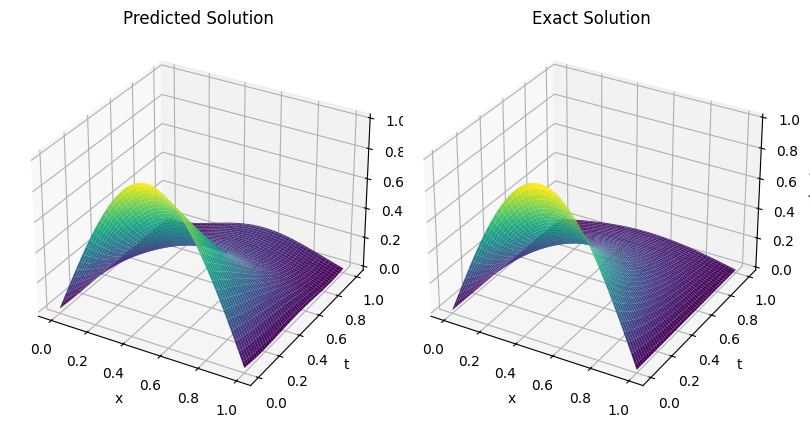

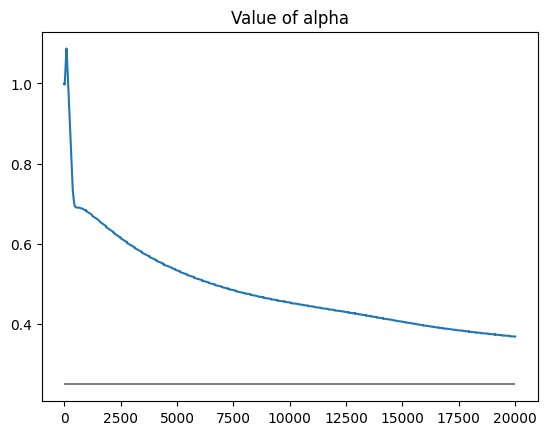

In [ ]:
epochs = 20001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
alphas = []

for epoch in range(epochs):
  with tf.GradientTape() as tape:

    up_b = tf.concat([model(xt_b0), model(xt_b1)], axis=0)
    up_i = model(Xt_i)

    b_loss = tf.reduce_mean(tf.square(up_b))
    i_loss = tf.reduce_mean(tf.square(up_i - u_i))

    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch([x_p,t_p])

      xt_p = tf.concat([x_p,t_p],axis=1)
      up_p = model(xt_p)

      u_t = tape2.gradient(up_p, t_p)
      u_x = tape2.gradient(up_p, x_p)
      u_xx = tape2.gradient(u_x, x_p)

      p_loss = tf.reduce_mean(tf.square(u_t - alpha_train * u_xx))

      del tape2

    up_obs = model(xt_obs)
    obs_loss = tf.reduce_mean(tf.square(up_obs - u_obs))

    loss = obs_loss + p_loss + b_loss + i_loss

  grads = tape.gradient(loss, model.trainable_variables + [alpha_train])
  optimizer.apply_gradients(zip(grads, model.trainable_variables + [alpha_train]))
  alphas.append(alpha_train.numpy().item())

  if epoch % 4000 == 0:
    print(f"Epoch {epoch}, Loss: {loss.numpy()}")

    u_pred = model(xt_test_tensor).numpy().reshape(100, 100)
    u_exact = exact_solution(xt_test[:,0], xt_test[:, 1]).numpy().reshape(100,100)

    fig = plt.figure(figsize=(8,6))

    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(x, t, u_pred, cmap='viridis')
    ax.set_title("Predicted Solution")
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_zlabel("u(x,t)")

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_surface(x, t, u_exact, cmap='viridis')
    ax.set_title("Exact Solution")
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_zlabel("u(x,t)")

    plt.tight_layout()
    plt.show()

plt.figure()
plt.title('Value of alpha')
plt.plot(alphas, label="PINN estimate")
plt.hlines(alpha, 0, len(alphas), label="True value", color="tab:grey")
plt.show()





